In [2]:
!pip install catboost

In [3]:
import catboost
import pandas as pd
from sklearn.model_selection import train_test_split

In [4]:
is_city_age_disabled = False

In [5]:
features = pd.read_parquet("data/transformed.parquet")
d = ['client_id', 'target']
if is_city_age_disabled:
    d += ["city_code", "age_code"]
if 'city' in features.columns:
    features.city = features.city.fillna("Неизвестно")
X_train, X_test, y_train, y_test = train_test_split(features.drop(d, axis=1), features.target, stratify=features.target)
print(f"{len(X_train) / sum(y_train)} {len(X_test) / sum(y_test)}")

24.895256916996047 24.85207100591716


In [6]:
X_train.isna().any()

gender              False
nonresident_flag    False
city                False
years               False
dtype: bool

In [7]:
X_train.columns

Index(['gender', 'nonresident_flag', 'city', 'years'], dtype='object')

In [8]:
# tr_p = catboost.Pool(X_train, y_train, cat_features=list(X_train.columns))
# te_p = catboost.Pool(X_test, y_test, cat_features=list(X_train.columns))

In [9]:
tr_p = catboost.Pool(X_train, y_train, cat_features=["gender", "nonresident_flag"], text_features=["city"])
te_p = catboost.Pool(X_test, y_test, cat_features=["gender", "nonresident_flag"], text_features=["city"])

In [10]:
model = catboost.CatBoostClassifier(iterations=1000,
                                    auto_class_weights='Balanced',
                                    eval_metric="AUC",
                                   random_seed=20220612)

In [11]:
model.fit(tr_p, eval_set=te_p, use_best_model=True, plot=True, verbose=100)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.059248
0:	test: 0.5647093	best: 0.5647093 (0)	total: 52.5ms	remaining: 52.4s
100:	test: 0.6486666	best: 0.6603674 (70)	total: 419ms	remaining: 3.73s
200:	test: 0.6433410	best: 0.6603674 (70)	total: 765ms	remaining: 3.04s
300:	test: 0.6333952	best: 0.6603674 (70)	total: 1.13s	remaining: 2.62s
400:	test: 0.6281657	best: 0.6603674 (70)	total: 1.5s	remaining: 2.25s
500:	test: 0.6255631	best: 0.6603674 (70)	total: 1.86s	remaining: 1.85s
600:	test: 0.6256072	best: 0.6603674 (70)	total: 2.23s	remaining: 1.48s
700:	test: 0.6279749	best: 0.6603674 (70)	total: 2.77s	remaining: 1.18s
800:	test: 0.6268285	best: 0.6603674 (70)	total: 3.17s	remaining: 787ms
900:	test: 0.6212577	best: 0.6603674 (70)	total: 3.56s	remaining: 391ms
999:	test: 0.6170448	best: 0.6603674 (70)	total: 3.94s	remaining: 0us

bestTest = 0.6603673601
bestIteration = 70

Shrink model to first 71 iterations.


In [12]:
print(dict(zip(X_test.columns, model.feature_importances_)))

{'gender': 12.165147880680264, 'nonresident_flag': 5.414027629428881, 'city': 48.42681888314412, 'years': 33.99400560674669}


In [13]:
X_test

gender nonresident_flag       city  years
317        Ж                R      Чишмы     68
14567      Ж                R     Москва     35
11141      Ж                R     Баймак     46
1332       М                R     Москва     44
15817      М                R     Москва     46
...      ...              ...        ...    ...
11758      Ж                R      Анапа     31
9265       Ж                R      Дубна     62
4339       Ж                R  Челябинск     67
769        Ж                R        Уфа     38
11261      М                R   Белорецк     60

[4200 rows x 4 columns]

In [14]:
model.save_model("model.cbm")

In [15]:
x_ = X_test.copy()
x_['predict'] = model.predict(X_test)

In [16]:
x_[x_['predict'] == 1]

gender nonresident_flag             city  years  predict
14567      Ж                R           Москва     35        1
1332       М                R           Москва     44        1
15817      М                R           Москва     46        1
13656      Ж                R           Москва     52        1
3778       М                R  Санкт-Петербург     51        1
...      ...              ...              ...    ...      ...
10283      М                R           Москва     56        1
1949       Ж                R           Покров     50        1
11815      М                R         Осинники     32        1
3711       М                R  Санкт-Петербург     60        1
8542       М                R           Брянск     34        1

[1713 rows x 5 columns]

In [17]:
sum(model.predict(X_test))

1713

In [18]:
from sklearn.metrics import classification_report
print(classification_report(y_test, x_['predict']))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      4031
           1       0.06      0.61      0.11       169

    accuracy                           0.60      4200
   macro avg       0.52      0.61      0.43      4200
weighted avg       0.94      0.60      0.72      4200



In [19]:
from sklearn.metrics import classification_report
print(classification_report(y_test, x_['predict']))

              precision    recall  f1-score   support

           0       0.97      0.60      0.74      4031
           1       0.06      0.61      0.11       169

    accuracy                           0.60      4200
   macro avg       0.52      0.61      0.43      4200
weighted avg       0.94      0.60      0.72      4200



In [20]:
# фича кросс город и возраст

In [21]:
X_test.iloc[0]

gender                  Ж
nonresident_flag        R
city                Чишмы
years                  68
Name: 317, dtype: object

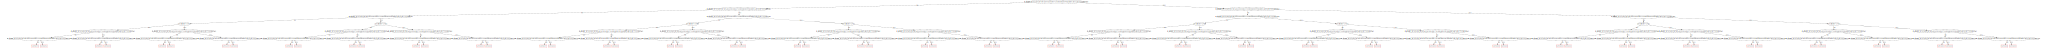

In [31]:
model.plot_tree(tree_idx=16, pool=te_p)